In [3]:
import numpy as np
from numpy.fft import fft2, ifft2
import scipy as sp
import sigpy
import sigpy.mri as mr
import sigpy.plot as pl#
import matplotlib.pyplot as plt
import time
import cupy as cp
from fastmri import fft2c, ifft2c, rss_complex, rss
from fastmri.data.subsample import RandomMaskFunc, EquispacedMaskFunc
from fastmri.evaluate import mse, nmse, psnr, ssim


kspace: (8, 230, 180) complex64


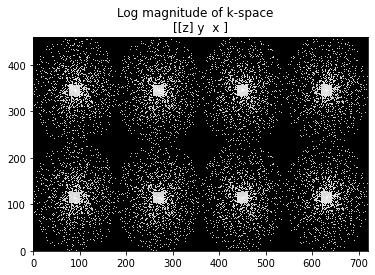

EspiritCalib:   0%|          | 0/100 [00:00<?, ?it/s]

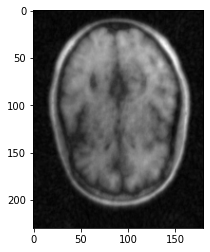

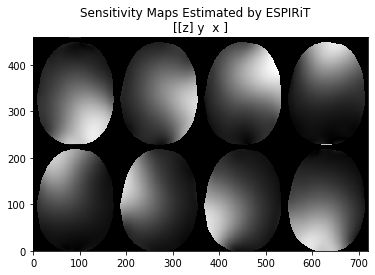

Sensitivity maps: (8, 230, 180) complex64


In [6]:
ksp_path = '/home/batman/Documents/sigpy_tutorial/sigpy-mri-tutorial/data/' # undersampled
ksp = np.load(ksp_path + 'cartesian_ksp.npy')
print('kspace:', ksp.shape, ksp.dtype)
pl.ImagePlot(ksp, mode='l', z=0, title='Log magnitude of k-space')



img_mc = np.abs(sigpy.ifft(ksp, axes=(-1, -2))) # image space multicoil
img_rss = np.sum(img_mc**2, axis=0)**0.5
plt.imshow(img_rss, cmap='gray')

# get smaps
mps = mr.app.EspiritCalib(ksp).run()
pl.ImagePlot(mps, z=0, title='Sensitivity Maps Estimated by ESPIRiT')
print('Sensitivity maps:', mps.shape, mps.dtype)

#### Sigpy SENSE recon

SenseRecon:   0%|          | 0/10 [00:00<?, ?it/s]

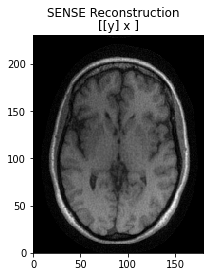

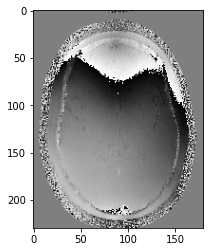

In [7]:
lamda = 0.01
# 32 bit
img_sense = mr.app.SenseRecon(ksp, mps, lamda=lamda, solver='ConjugateGradient', max_iter=10).run()

pl.ImagePlot(img_sense, title='SENSE Reconstruction')
plt.imshow(np.flip(np.angle(img_sense)), cmap='gray')


#### manual condition number for k-space and recon'd image

In [24]:
# kspace
for x in range(ksp.shape[0]):
    uk, sk, vk = np.linalg.svd(ksp[x,:,:])
    cnk = sk.max()/sk.min()
    print('Coil ' + str(x) + ' condition number:',  cnk)

# image
ui, si, vi = np.linalg.svd(img_sense_32)
cni = si.max()/si.min()
print('Reconstructed image condition number:', cni)

Coil 0 condition number: 1.2597259e+16
Coil 1 condition number: 1.2113975e+16
Coil 2 condition number: 1.3448391e+16
Coil 3 condition number: 1.2242645e+16
Coil 4 condition number: 1.3362672e+16
Coil 5 condition number: 1.3218598e+16
Coil 6 condition number: 1.1186882e+16
Coil 7 condition number: 1.299929e+16
Reconstructed image condition number: 1.358028e+16


#### numpy/CG-SENSE recon

Iteration: 0
Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 0
Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 0
Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
PSNR: 44.71151172669263
NMSE: 0.0004558058119600637
SSIM: 0.9907773308140922


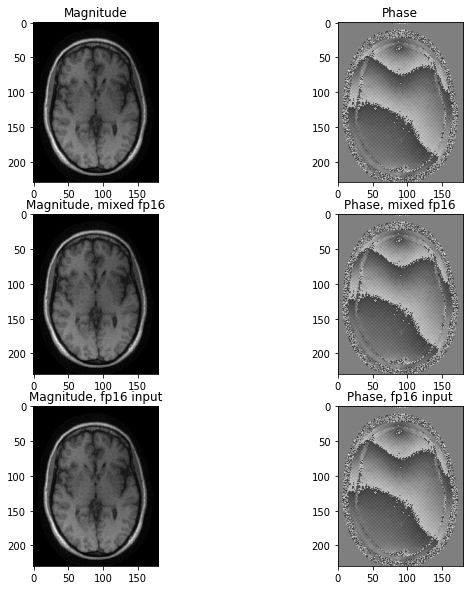

In [4]:
def to_fp16(x):
    real_part = x.real.astype(np.float16)
    imag_part = x.imag.astype(np.float16)
    return real_part + 1j * imag_part

def conjugate_sense_reconstruction(kspace, sensitivity_maps, num_iters=50, lamda=1e-2, tol=1e-10, use_fp16=False):
    """
    Conjugate Gradient SENSE MRI Reconstruction
    
    Parameters:
    - kspace: numpy array of shape (num_coil, nrows, ncols), the k-space data
    - sensitivity_maps: numpy array of shape (num_coil, nrows, ncols), sensitivity maps
    - num_iters: int, number of iterations for the CG algorithm
    - lamda: float, regularization parameter
    - tol: float, tolerance for stopping condition
    
    Returns:
    - x: numpy array of shape (nrows, ncols), complex-valued reconstructed image
    """
    num_coil, nrows, ncols = kspace.shape

    # Estimate weights using RSS of k-space data
    # weights = np.sqrt(np.sum(np.abs(kspace)**2, axis=0))
    # weights[weights == 0] = 1  # Avoid division by zero
    # kspace = kspace * np.sqrt(weights)

    def get_weights(y):
        return (np.sqrt(np.sum(np.square(y), axis=0)) > 0).astype(y.dtype)

    W = get_weights(kspace)

    # making linear operator FSx

    def forward_op(x):
        """Forward operation: SENSE forward model."""
        x_expand = np.expand_dims(x, axis=0)
        shifted_image = np.fft.fftshift(sensitivity_maps * x_expand, axes=(1, 2)) # need to shift
        return W**0.5 * np.fft.fft2(shifted_image, norm='ortho')

    # x* FHSH
    def adjoint_op(y):
        """Adjoint operation: SENSE adjoint model."""
        ifft_result = np.fft.ifft2(y, norm='ortho')
        shifted_ifft_result = np.fft.ifftshift(ifft_result, axes=(1, 2)) # need to shift
        return np.sum(sensitivity_maps.conj() * shifted_ifft_result, axis=0)

    # Define AHA operator: A^H A + lambda I
    def normal_op(x):
        """Normal equation operator: A^H A + lambda I"""
        result = adjoint_op(forward_op(x)) + lamda * x
        if use_fp16:
            return to_fp16(result)
        else:
            return result

    # Compute AHy (adjoint of k-space) # could be different phase
    if use_fp16:
        AHy = to_fp16(adjoint_op(kspace))
    else:
        AHy = adjoint_op(kspace) 

    # init
    x = np.zeros_like(AHy)  # 0s init
    if use_fp16:
        r = to_fp16(AHy - normal_op(x))
    else:   
        r = AHy - normal_op(x) 
    z = r.copy() # if preconditioning here)
    p = z.copy()

    rz_old = np.vdot(r, z)
    resid = np.sqrt(rz_old)

    # now do cg iterations
    for i in range(num_iters):
        if use_fp16:
            Ap = to_fp16(normal_op(p))
        else:
            Ap = normal_op(p) 
        pAp = np.vdot(p, Ap)

        if pAp <= 0:
            print("Matrix not positive definite. Stopping.")
            break

        alpha = rz_old / pAp
        x += alpha * p
        r -= alpha * Ap

        if use_fp16:
            z = to_fp16(r)  # No preconditioning
        else:
            z = r
        rz_new = np.vdot(r, z)

        resid = np.sqrt(rz_new)

        if resid < tol:
            print(f'Converged after {i+1} iterations with residual {resid}')
            break

        beta = rz_new / rz_old
        if use_fp16:
            p = to_fp16(z + beta * p)
        else:
            p = z + beta * p
        rz_old = rz_new

        if i % 10 == 0:
            print("Iteration:", i) 
    return x  # Return complex-valued image

# def to_fp16(x):
#     real_part = x.real.astype(np.float16)
#     imag_part = x.imag.astype(np.float16)
#     return real_part + 1j * imag_part

# def conjugate_sense_reconstruction(kspace, sensitivity_maps, num_iters=50, lamda=1e-2, tol=1e-10, use_fp16=False):
#     """
#     Conjugate Gradient SENSE MRI Reconstruction
    
#     Parameters:
#     - kspace: numpy array of shape (num_coil, nrows, ncols), the k-space data
#     - sensitivity_maps: numpy array of shape (num_coil, nrows, ncols), sensitivity maps
#     - num_iters: int, number of iterations for the CG algorithm
#     - lamda: float, regularization parameter
#     - tol: float, tolerance for stopping condition
    
#     Returns:
#     - x: numpy array of shape (nrows, ncols), complex-valued reconstructed image
#     """
#     num_coil, nrows, ncols = kspace.shape

#     def get_weights(y):
#         return (np.sqrt(np.sum(np.square(y), axis=0)) > 0).astype(y.dtype)

#     W = get_weights(kspace)

#     def forward_op(x):
#         """Forward operation: SENSE forward model."""
#         x_expand = np.expand_dims(x, axis=0)
#         shifted_image = np.fft.fftshift(sensitivity_maps * x_expand, axes=(1, 2))
#         result = W**0.5 * np.fft.fft2(shifted_image, norm='ortho')
#         return to_fp16(result) if use_fp16 else result

#     def adjoint_op(y):
#         """Adjoint operation: SENSE adjoint model."""
#         ifft_result = np.fft.ifft2(y, norm='ortho')
#         shifted_ifft_result = np.fft.ifftshift(ifft_result, axes=(1, 2))
#         result = np.sum(sensitivity_maps.conj() * shifted_ifft_result, axis=0)
#         return to_fp16(result) if use_fp16 else result

#     def normal_op(x):
#         """Normal equation operator: A^H A + lambda I"""
#         result = adjoint_op(forward_op(x)) + lamda * x  # Keep lambda term in full precision
#         return to_fp16(result) if use_fp16 else result

#     if use_fp16:
#         AHy = to_fp16(adjoint_op(kspace))
#     else:
#         AHy = adjoint_op(kspace)

#     x = np.zeros_like(AHy)
#     r = to_fp16(AHy - normal_op(x)) if use_fp16 else AHy - normal_op(x)
#     z = r.copy()
#     p = z.copy()

#     rz_old = np.vdot(r, z)
#     resid = np.sqrt(rz_old)

#     for i in range(num_iters):
#         Ap = to_fp16(normal_op(p)) if use_fp16 else normal_op(p)
#         pAp = np.vdot(p, Ap)  # Full precision dot product

#         if pAp <= 0:
#             print("Matrix not positive definite. Stopping.")
#             break

#         alpha = rz_old / pAp
#         x += alpha * p
#         r -= alpha * Ap

#         if use_fp16:
#             z = to_fp16(r)  # No preconditioning
#         else:
#             z = r

#         rz_new = np.vdot(r, z)  # Full precision dot product
#         resid = np.sqrt(rz_new)

#         if resid < tol:
#             print(f'Converged after {i+1} iterations with residual {resid}')
#             break

#         beta = rz_new / rz_old
#         p = to_fp16(z + beta * p) if use_fp16 else z + beta * p
#         rz_old = rz_new

#         if i % 10 == 0:
#             print("Iteration:", i)

#     return x  # Return complex-valued image




recon_img = conjugate_sense_reconstruction(ksp, mps, lamda=1e-2)
recon_img_16b = conjugate_sense_reconstruction(ksp, mps, lamda=1e-2, use_fp16=True) 
recon_img_16b_input = conjugate_sense_reconstruction(to_fp16(ksp), to_fp16(mps), lamda=1e-2, use_fp16=False) 


plt.figure(figsize=(10,10))
plt.subplot(321)
plt.imshow(np.abs(np.flip(recon_img)), cmap='gray')
plt.title('Magnitude')
plt.subplot(322)
plt.imshow(np.angle(np.flip(recon_img)), cmap='gray')
plt.title('Phase')
plt.subplot(323)
plt.imshow(np.abs(np.flip(recon_img_16b)), cmap='gray')
plt.title('Magnitude, mixed fp16')
plt.subplot(324)
plt.imshow(np.angle(np.flip(recon_img_16b)), cmap='gray')
plt.title('Phase, mixed fp16')

plt.subplot(325)
plt.imshow(np.abs(np.flip(recon_img_16b_input)), cmap='gray')
plt.title('Magnitude, fp16 input')
plt.subplot(326)
plt.imshow(np.angle(np.flip(recon_img_16b_input)), cmap='gray')
plt.title('Phase, fp16 input')

# image quality stats
psnr_recon = psnr(np.abs(img_sense), np.abs(recon_img_16b_input))
nmse_recon = nmse(np.abs(img_sense), np.abs(recon_img_16b_input))
ssim_recon = ssim(np.expand_dims(np.abs(img_sense), axis=0), np.expand_dims(np.abs(recon_img_16b_input), axis=0))
print("PSNR:", psnr_recon)
print("NMSE:", nmse_recon)
print("SSIM:", ssim_recon)




#### CuPy implementation

PSNR: 43.689440648162176
NMSE: 0.0005767491116150631
SSIM: 0.9885514559050553


Text(0.5, 1.0, 'Phase, fp16 input')

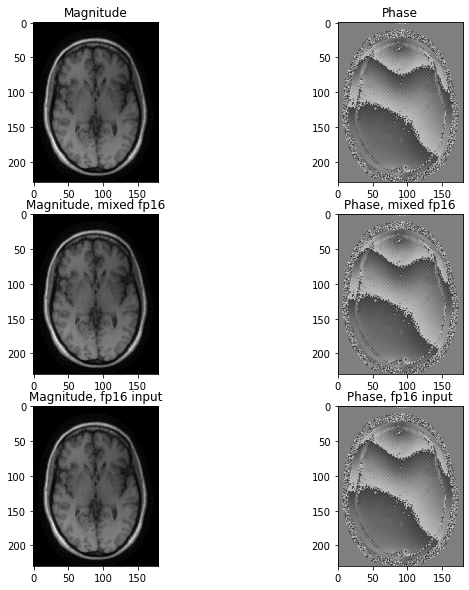

In [4]:
def to_fp16(x):
    """Convert complex64 to simulated complex16 using CuPy by converting real and imaginary parts separately to float16."""
    real_part = cp.real(x).astype(cp.float16)
    imag_part = cp.imag(x).astype(cp.float16)
    return real_part + 1j * imag_part

def low_rank_approximation(sensitivity_maps, rank):
    # Flatten the sensitivity maps: shape (num_coils, nrows, ncols) -> (num_coils, nrows * ncols)
    num_coils, nrows, ncols = sensitivity_maps.shape
    reshaped_maps = sensitivity_maps.reshape(num_coils, -1)

    # Apply SVD
    U, S, Vh = cp.linalg.svd(reshaped_maps, full_matrices=False)

    # Retain only the top `rank` components
    U_reduced = U[:, :rank]
    S_reduced = S[:rank]
    Vh_reduced = Vh[:rank, :]

    # Reconstruct the low-rank approximation
    approx_maps = U_reduced @ cp.diag(S_reduced) @ Vh_reduced

    # Reshape back to the original shape
    approx_maps = approx_maps.reshape(num_coils, nrows, ncols)
    return approx_maps

def conjugate_sense_reconstruction_gpu(kspace, sensitivity_maps, num_iters=50, lamda=1e-2, tol=1e-10, use_fp16=False):
    """
    Conjugate Gradient SENSE MRI Reconstruction with CuPy for GPU-accelerated computation.
    
    Parameters:
    - kspace: CuPy array of shape (num_coil, nrows, ncols), the k-space data
    - sensitivity_maps: CuPy array of shape (num_coil, nrows, ncols), sensitivity maps
    - num_iters: int, number of iterations for the CG algorithm
    - lamda: float, regularization parameter
    - tol: float, tolerance for stopping condition
    - use_fp16: bool, whether to use mixed precision with FP16 for certain operations
    
    Returns:
    - x: CuPy array of shape (nrows, ncols), complex-valued reconstructed image
    """
    num_coil, nrows, ncols = kspace.shape

    # if use_fp16:
    #     print('using now')
    #     sensitivity_maps = low_rank_approximation(sensitivity_maps, rank=3)
    

    # Estimate weights using RSS of k-space data
    def get_weights(y):
        return (cp.sqrt(cp.sum(cp.abs(y)**2, axis=0)) > 0).astype(y.dtype)

    W = get_weights(kspace)

    # Define the forward operator for SENSE model
    def forward_op(x):
        """Forward operation: SENSE forward model."""
        x_expand = cp.expand_dims(x, axis=0)
        shifted_image = cp.fft.fftshift(sensitivity_maps * x_expand, axes=(1, 2))
        return W**0.5 * cp.fft.fft2(shifted_image, norm='ortho')

    # Define the adjoint operator for SENSE model
    def adjoint_op(y):
        """Adjoint operation: SENSE adjoint model."""
        ifft_result = cp.fft.ifft2(y, norm='ortho')
        shifted_ifft_result = cp.fft.ifftshift(ifft_result, axes=(1, 2))
        return cp.sum(sensitivity_maps.conj() * shifted_ifft_result, axis=0)

    # Define AHA operator: A^H A + lambda I
    def normal_op(x):
        """Normal equation operator: A^H A + lambda I"""
        result = adjoint_op(forward_op(x)) + lamda * x
        return to_fp16(result) if use_fp16 else result

    # Compute AHy (adjoint of k-space)
    AHy = adjoint_op(kspace)

    # Initialization
    x = cp.zeros_like(AHy, dtype=cp.complex64)  # Keep x in complex64 for accuracy
    r = AHy - normal_op(x)  # Residual, kept in complex64 for stability
    z = to_fp16(r) if use_fp16 else r  # Preconditioned residual, cast to 16-bit if mixed precision
    p = z.copy()  # Search direction, cast to 16-bit if mixed precision

    rz_old = cp.vdot(r, z)  # Dot product in complex64 for stability
    resid = cp.sqrt(cp.abs(rz_old))

    # Conjugate Gradient iterations
    for i in range(num_iters):
        Ap = to_fp16(normal_op(p)) if use_fp16 else normal_op(p)  # Matrix-vector product in 16-bit for mixed precision
        pAp = cp.vdot(p, Ap)  # Dot product in complex64 for stable step size calculation

        if pAp <= 0:
            print("Matrix not positive definite. Stopping.")
            break

        alpha = rz_old / pAp
        x += alpha * p  # Update solution in complex64
        r -= alpha * Ap  # Update residual in complex64 for accuracy

        z = to_fp16(r) if use_fp16 else r  # Update preconditioned residual, cast to 16-bit if mixed precision
        rz_new = cp.vdot(r, z)  # Dot product in complex64 for stability
        resid = cp.sqrt(cp.abs(rz_new))

        if resid < tol:
            print(f'Converged after {i+1} iterations with residual {resid}')
            break

        beta = rz_new / rz_old
        p = to_fp16(z + beta * p) if use_fp16 else z + beta * p  # Update search direction in 16-bit for mixed precision
        rz_old = rz_new

        # if i % 10 == 0:
        #     print("Iteration:", i) 
    return x  # Return complex-valued image


ksp = cp.array(ksp)
mps = cp.array(mps)

recon_img = conjugate_sense_reconstruction_gpu(ksp, mps, lamda=1e-2)
recon_img = cp.asnumpy(recon_img)

recon_img_16b = conjugate_sense_reconstruction_gpu(ksp, mps, lamda=1e-2, use_fp16=True) 
recon_img_16b = cp.asnumpy(recon_img_16b)

recon_img_16b_input = conjugate_sense_reconstruction_gpu(to_fp16(ksp), to_fp16(mps), lamda=1e-2, use_fp16=False) 
recon_img_16b_input = cp.asnumpy(recon_img_16b_input)

psnr_recon = psnr(np.abs(img_sense), np.abs(recon_img_16b))
nmse_recon = nmse(np.abs(img_sense), np.abs(recon_img_16b))
ssim_recon = ssim(np.expand_dims(np.abs(img_sense), axis=0), np.expand_dims(np.abs(recon_img_16b), axis=0))
print("PSNR:", psnr_recon)
print("NMSE:", nmse_recon)
print("SSIM:", ssim_recon)


plt.figure(figsize=(10,10))
plt.subplot(321)
plt.imshow(np.abs(np.flip(recon_img)), cmap='gray')
plt.title('Magnitude')
plt.subplot(322)
plt.imshow(np.angle(np.flip(recon_img)), cmap='gray')
plt.title('Phase')
plt.subplot(323)
plt.imshow(np.abs(np.flip(recon_img_16b)), cmap='gray')
plt.title('Magnitude, mixed fp16')
plt.subplot(324)
plt.imshow(np.angle(np.flip(recon_img_16b)), cmap='gray')
plt.title('Phase, mixed fp16')

plt.subplot(325)
plt.imshow(np.abs(np.flip(recon_img_16b_input)), cmap='gray')
plt.title('Magnitude, fp16 input')
plt.subplot(326)
plt.imshow(np.angle(np.flip(recon_img_16b_input)), cmap='gray')
plt.title('Phase, fp16 input')



In [ ]:
def to_fp16(x):
    """Convert complex64 to simulated complex16 using CuPy by converting real and imaginary parts separately to float16."""
    real_part = cp.real(x).astype(cp.float16)
    imag_part = cp.imag(x).astype(cp.float16)
    return real_part + 1j * imag_part

def conjugate_sense_reconstruction_gpu(kspace, sensitivity_maps, num_iters=50, lamda=1e-2, tol=1e-10, use_fp16=False):
    num_coil, nrows, ncols = kspace.shape

    def get_weights(y):
        return (cp.sqrt(cp.sum(cp.abs(y)**2, axis=0)) > 0).astype(y.dtype)

    W = get_weights(kspace)

    def forward_op(x):
        """Forward operation: SENSE forward model."""
        x_expand = cp.expand_dims(x, axis=0)
        shifted_image = cp.fft.fftshift(sensitivity_maps * x_expand, axes=(1, 2))
        return W**0.5 * cp.fft.fft2(shifted_image, norm='ortho')

    def adjoint_op(y):
        """Adjoint operation: SENSE adjoint model."""
        ifft_result = cp.fft.ifft2(y, norm='ortho')
        shifted_ifft_result = cp.fft.ifftshift(ifft_result, axes=(1, 2))
        return cp.sum(sensitivity_maps.conj() * shifted_ifft_result, axis=0)

    def normal_op(x):
        """Normal equation operator: A^H A + lambda I"""
        result = adjoint_op(forward_op(x)) + lamda * x
        return to_fp16(result) if use_fp16 else result

    AHy = adjoint_op(kspace)

    # Initialization with minimal memory usage
    x = cp.zeros_like(AHy, dtype=cp.complex64)  # Final output remains in complex64
    r = AHy - normal_op(x)
    z = to_fp16(r) if use_fp16 else r  # Cast to FP16 if using mixed precision
    p = z.copy()  # Reuse variables for in-place operations

    rz_old = cp.vdot(r, z)
    resid = cp.sqrt(cp.abs(rz_old))

    # Conjugate Gradient iterations
    for i in range(num_iters):
        Ap = normal_op(p)  # Compute normal_op(p) as complex16 if use_fp16 is True
        if use_fp16:
            Ap = to_fp16(Ap)

        pAp = cp.vdot(p, Ap)  # Full precision for stable step calculation

        if pAp <= 0:
            break

        alpha = rz_old / pAp
        x += alpha * p  # Update x in full precision (complex64)
        r -= alpha * Ap  # Update r in full precision

        z = to_fp16(r) if use_fp16 else r  # Reuse r for z, cast to FP16 if necessary
        rz_new = cp.vdot(r, z)  # Full precision for dot products
        resid = cp.sqrt(cp.abs(rz_new))

        if resid < tol:
            break

        beta = rz_new / rz_old
        p *= beta  # In-place update for p
        p += z  # Update p with the new search direction
        rz_old = rz_new

    # Return the magnitude of the final complex image
    return cp.abs(x)

#### FLOPs/memory usage

In [9]:
import cupy as cp

def profile_reconstruction(nrows, ncols, num_coil, num_iters=50, lamda=1e-2, tol=1e-10, use_fp16=False):
    # Set custom memory pool to track GPU memory usage
    cp.cuda.set_allocator(cp.cuda.MemoryPool().malloc)


    device = cp.cuda.Device(0)
    
    # get total and available GPU memory before computation
    total_gpu_memory = device.mem_info[1] / (1024 ** 2)  # Total memory in MB
    used_memory_before = (device.mem_info[1] - device.mem_info[0]) / (1024 ** 2)  # Used memory in MB
    print(f"Total GPU Memory: {total_gpu_memory:.2f} MB")
    print(f"Used GPU Memory before computation: {used_memory_before:.2f} MB")

    # send kspace and smaps to gpu
    kspace = cp.array(to_fp16(ksp))
    sensitivity_maps = cp.array(to_fp16(mps))

    # start memory tracking, cuda profiling, and "event"
    used_memory_during_allocation = (device.mem_info[1] - device.mem_info[0]) / (1024 ** 2)
    peak_memory_usage = max(used_memory_before, used_memory_during_allocation)

    start_event = cp.cuda.Event()
    end_event = cp.cuda.Event()

    start_event.record()

    # do recon
    result = conjugate_sense_reconstruction_gpu(kspace, sensitivity_maps, num_iters=num_iters, lamda=lamda, tol=tol, use_fp16=use_fp16)
    
    end_event.record()
    end_event.synchronize()

  
    elapsed_time_ms = cp.cuda.get_elapsed_time(start_event, end_event)
    elapsed_time_s = elapsed_time_ms / 1000 # ms to s

    # get gpu memory usage after computation
    used_memory_after = (device.mem_info[1] - device.mem_info[0]) / (1024 ** 2) 
    print(f"Used GPU Memory after computation: {used_memory_after:.2f} MB")

    # Update peak memory usage after computation - check if this is correct
    peak_memory_usage = max(peak_memory_usage, used_memory_after)
    memory_used_by_computation = used_memory_after - used_memory_before
    print(f"Memory used by computation: {memory_used_by_computation:.2f} MB")
    print(f"Peak GPU Memory Usage: {peak_memory_usage:.2f} MB")

    # here calculate FLOPS for fp16 and fp32 separately
    num_elements = nrows * ncols
    fft_flops = 2 * 5 * num_elements * cp.log2(num_elements) # 5N*logN fft flops
    dot_product_flops = 2 * num_elements  # each dot product takes 2N flops
    vector_update_flops = 3 * num_elements  # 3 updates per iteration

    flops_per_iteration_fp32 = 0
    flops_per_iteration_fp16 = 0

    # fp32 ops (dot products, x, r updates)
    flops_per_iteration_fp32 += 2 * dot_product_flops  # rz_old and pAp dot products
    flops_per_iteration_fp32 += vector_update_flops  # x and r updates

    # fp16 ops (Ap, z, p updates if use_fp16)
    if use_fp16:
        flops_per_iteration_fp16 += fft_flops  # FFTs on p in mixed precision
        flops_per_iteration_fp16 += vector_update_flops  # z, p updates
    else:
        flops_per_iteration_fp32 += fft_flops + vector_update_flops  # All flops in FP32 if not using FP16

    # theoretical flops across iteraitons
    total_flops_fp32 = flops_per_iteration_fp32 * num_iters
    total_flops_fp16 = flops_per_iteration_fp16 * num_iters
    total_flops = total_flops_fp32 + total_flops_fp16  # combined theoretical flops (not sure how to interpret)

    # get effective FLOPS/s; this should be real-time measurement
    flops_per_second_fp32 = total_flops_fp32 / elapsed_time_s
    flops_per_second_fp16 = total_flops_fp16 / elapsed_time_s
    flops_per_second_total = total_flops / elapsed_time_s

    # convert everything to float
    total_flops_fp32 = float(total_flops_fp32)
    total_flops_fp16 = float(total_flops_fp16)
    total_flops = float(total_flops)
    flops_per_second_fp32 = float(flops_per_second_fp32)
    flops_per_second_fp16 = float(flops_per_second_fp16)
    flops_per_second_total = float(flops_per_second_total)


    print(f"{'Mixed Precision' if use_fp16 else 'Full Precision'} (FP{16 if use_fp16 else 32}) Results:")
    print(f"Total FP32-only FLOPs: {total_flops_fp32:.2e}")
    print(f"Total FP16-only FLOPs: {total_flops_fp16:.2e}")
    print(f"Total FLOPs (Combined): {total_flops:.2e}")
    print(f"FP32 FLOPs per second: {flops_per_second_fp32:.2e}")
    print(f"FP16 FLOPs per second: {flops_per_second_fp16:.2e}")
    print(f"Total FLOPs per second: {flops_per_second_total:.2e}")
    print(f"Elapsed Time: {elapsed_time_s:.4f} seconds\n")
    print(f"Total GPU Memory: {total_gpu_memory:.2f} MB")
    print(f"Used GPU Memory before computation: {used_memory_before:.2f} MB")
    print(f"Used GPU Memory after computation: {used_memory_after:.2f} MB")
    print(f"Memory used by computation: {memory_used_by_computation:.2f} MB")
    print(f"Peak GPU Memory Usage: {peak_memory_usage:.2f} MB\n")

# Parameters
nrows, ncols = 230, 180
num_coil = 8
num_iters = 50

# Run profiling for FP16 and FP32
profile_reconstruction(nrows, ncols, num_coil, num_iters=num_iters, use_fp16=True)
profile_reconstruction(nrows, ncols, num_coil, num_iters=num_iters, use_fp16=False)



Total GPU Memory: 24220.31 MB
Used GPU Memory before computation: 290.94 MB
Used GPU Memory after computation: 324.94 MB
Memory used by computation: 34.00 MB
Peak GPU Memory Usage: 324.94 MB
Mixed Precision (FP16) Results:
Total FP32-only FLOPs: 1.45e+07
Total FP16-only FLOPs: 3.24e+08
Total FLOPs (Combined): 3.38e+08
FP32 FLOPs per second: 1.20e+08
FP16 FLOPs per second: 2.67e+09
Total FLOPs per second: 2.79e+09
Elapsed Time: 0.1212 seconds

Total GPU Memory: 24220.31 MB
Used GPU Memory before computation: 290.94 MB
Used GPU Memory after computation: 324.94 MB
Memory used by computation: 34.00 MB
Peak GPU Memory Usage: 324.94 MB

Total GPU Memory: 24220.31 MB
Used GPU Memory before computation: 290.94 MB
Used GPU Memory after computation: 324.94 MB
Memory used by computation: 34.00 MB
Peak GPU Memory Usage: 324.94 MB
Full Precision (FP32) Results:
Total FP32-only FLOPs: 3.38e+08
Total FP16-only FLOPs: 0.00e+00
Total FLOPs (Combined): 3.38e+08
FP32 FLOPs per second: 3.16e+09
FP16 FLOPs

#### PSNR, NMSE, SSIM

[122.59126929061173, 54.90521981904492, 34.668599967389035, 2.6253995939784422, 6.462136902127719]
[7.426839403368074e-12, 4.359222380926962e-05, 0.004603318135590059, 7.368703781089336, 3.045911864293147]
[0.9999999998589796, 0.9991484294229335, 0.931249163647, 0.21301385902246892, 0.24220579873000203]


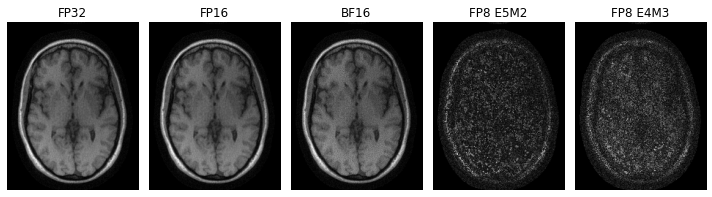

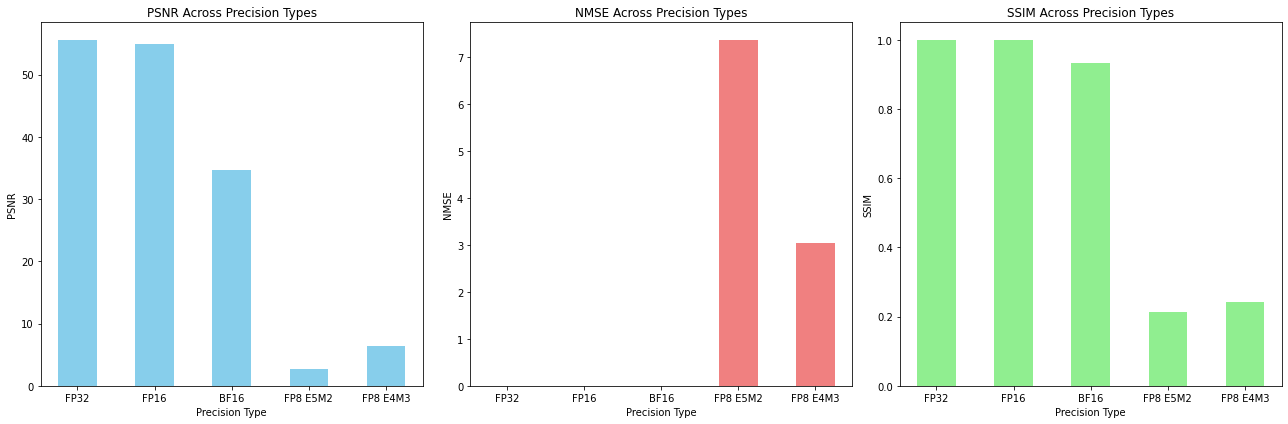

In [27]:
fp32 = np.load('/home/batman/Documents/ma221/recon_img.npy')
fp16=np.load('/home/batman/Documents/ma221/recon_img_fp16.npy')
bf16=np.load('/home/batman/Documents/ma221/recon_img_bf16.npy')
fp8_e5m2=np.load('/home/batman/Documents/ma221/recon_img_fp8_e5m2.npy')
fp8_e4m3=np.load('/home/batman/Documents/ma221/recon_img_fp8_e4m3.npy')
# psnr_recon = psnr(np.abs(img_sense), np.abs(recon_img_16b_input))
# nmse_recon = nmse(np.abs(img_sense), np.abs(recon_img_16b_input))
# ssim_recon = ssim(np.expand_dims(np.abs(img_sense), axis=0), np.expand_dims(np.abs(recon_img_16b_input), axis=0))
# print("PSNR:", psnr_recon)
# print("NMSE:", nmse_recon)
# print("SSIM:", ssim_recon)
plt.figure(figsize=(10,10))
plt.subplot(151)
plt.imshow(np.abs(np.flip(fp32)), cmap='gray')
plt.title('FP32')
plt.axis('off')
plt.subplot(152)
plt.imshow(np.abs(np.flip(fp16)), cmap='gray')
plt.title('FP16')
plt.axis('off')
plt.subplot(153)
plt.imshow(np.abs(np.flip(bf16)), cmap='gray')
plt.title('BF16')
plt.axis('off')
plt.subplot(154)
plt.imshow(np.abs(np.flip(fp8_e5m2)), cmap='gray')
plt.title('FP8 E5M2')
plt.axis('off')
plt.subplot(155)
plt.imshow(np.abs(np.flip(fp8_e4m3)), cmap='gray')
plt.title('FP8 E4M3')
plt.axis('off')
plt.tight_layout()

img_list = [fp32, fp16, bf16, fp8_e5m2, fp8_e4m3]
psnr_list = [psnr(np.abs(img_sense), np.abs(i)) for i in img_list]
nmse_list = [nmse(np.abs(img_sense), np.abs(i)) for i in img_list]
ssim_list = [ssim(np.expand_dims(np.abs(img_sense), axis=0), np.expand_dims(np.abs(i), axis=0)) for i in img_list]
print(psnr_list)
print(nmse_list)
print(ssim_list)

# Data arrays
psnr_values_fp = [55.59126929061173, 54.90521981904492, 34.668599967389035, 2.6253995939784422, 6.462136902127719]
nmse_values_fp = [7.426839403368074e-12, 4.359222380926962e-05, 0.004603318135590059, 7.368703781089336, 3.045911864293147]
ssim_values_fp = [0.9999999998589796, 0.9991484294229335, 0.931249163647, 0.21301385902246892, 0.24220579873000203]

# Labels for floating-point precision types
precision_types = ['FP32', 'FP16', 'BF16', 'FP8 E5M2', 'FP8 E4M3']
x_positions = np.arange(len(precision_types))
bar_width = 0.5

# Create separate bar plots for PSNR, NMSE, and SSIM
plt.figure(figsize=(18, 6))

# PSNR plot
plt.subplot(1, 3, 1)
plt.bar(x_positions, psnr_values_fp, width=bar_width, color='skyblue')
plt.xlabel('Precision Type')
plt.ylabel('PSNR')
plt.title('PSNR Across Precision Types')
plt.xticks(x_positions, precision_types)

# NMSE plot
plt.subplot(1, 3, 2)
plt.bar(x_positions, nmse_values_fp, width=bar_width, color='lightcoral')
plt.xlabel('Precision Type')
plt.ylabel('NMSE')
plt.title('NMSE Across Precision Types')
plt.xticks(x_positions, precision_types)

# SSIM plot
plt.subplot(1, 3, 3)
plt.bar(x_positions, ssim_values_fp, width=bar_width, color='lightgreen')
plt.xlabel('Precision Type')
plt.ylabel('SSIM')
plt.title('SSIM Across Precision Types')
plt.xticks(x_positions, precision_types)

plt.tight_layout()
plt.show()


[26.31753270739019, 25.364489756056336, 8.863710964836958, 18.679381839533807, 2.6253995939784422, 18.485311325782742]
[0.031490370028172475, 0.039217693747677196, 1.7521042698344291, 0.1828070208921696, 7.368703781089336, 0.19116128042780797]
[0.7957972643686602, 0.7888891926667693, 0.2534959143873815, 0.5197063902516392, 0.21301385902246892, 0.5091503592201594]
[26.501782780560287, 25.38168089626997, 14.988540124947855, 24.04337753681993, 6.462136902127719, 23.26398905256426]
[0.030182330763303115, 0.03906276631042541, 0.42763871708495377, 0.05316101869888283, 3.045911864293147, 0.0636109888384999]
[0.8130180093746928, 0.8037558305351783, 0.3859577067537905, 0.6972703324562063, 0.24220579873000203, 0.6531895425052957]


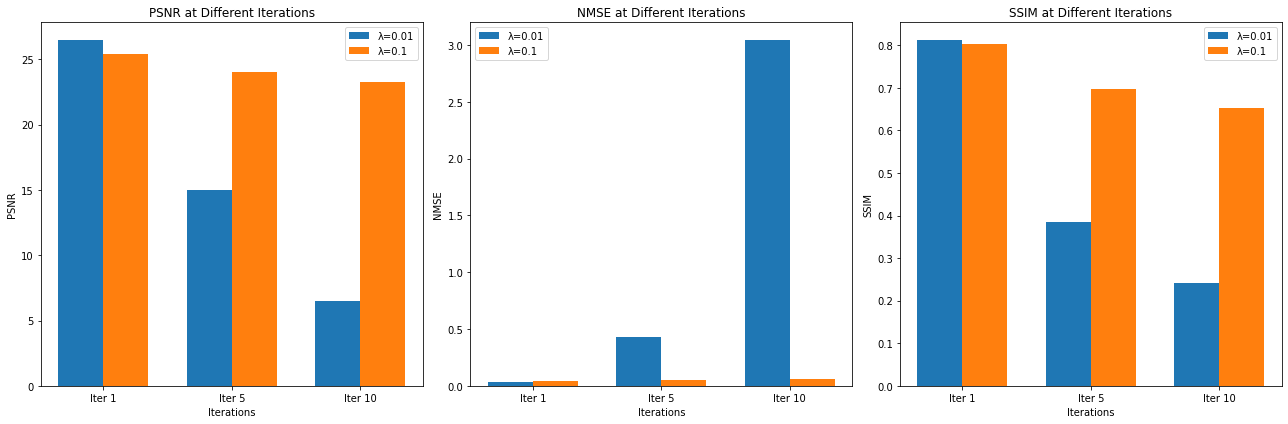

In [26]:
fp8_e5m2_0p01_iter10=np.load('/home/batman/Documents/ma221/recon_img_fp8_e5m2_0p01_iter10.npy')
fp8_e4m3_0p01_iter10=np.load('/home/batman/Documents/ma221/recon_img_fp8_e4m3_0p01_iter10.npy')
fp8_e5m2_0p1_iter10=np.load('/home/batman/Documents/ma221/recon_img_fp8_e5m2_0p1_iter10.npy')
fp8_e4m3_0p1_iter10=np.load('/home/batman/Documents/ma221/recon_img_fp8_e4m3_0p1_iter10.npy')

fp8_e5m2_0p01_iter1=np.load('/home/batman/Documents/ma221/recon_img_fp8_e5m2_0p01_iter1.npy')
fp8_e4m3_0p01_iter1=np.load('/home/batman/Documents/ma221/recon_img_fp8_e4m3_0p01_iter1.npy')
fp8_e5m2_0p1_iter1=np.load('/home/batman/Documents/ma221/recon_img_fp8_e5m2_0p1_iter1.npy')
fp8_e4m3_0p1_iter1=np.load('/home/batman/Documents/ma221/recon_img_fp8_e4m3_0p1_iter1.npy')

fp8_e5m2_0p01_iter5=np.load('/home/batman/Documents/ma221/recon_img_fp8_e5m2_0p01_iter5.npy')
fp8_e4m3_0p01_iter5=np.load('/home/batman/Documents/ma221/recon_img_fp8_e4m3_0p01_iter5.npy')
fp8_e5m2_0p1_iter5=np.load('/home/batman/Documents/ma221/recon_img_fp8_e5m2_0p1_iter5.npy')
fp8_e4m3_0p1_iter5=np.load('/home/batman/Documents/ma221/recon_img_fp8_e4m3_0p1_iter5.npy')

e5m2_list = [fp8_e5m2_0p01_iter1, fp8_e5m2_0p1_iter1, fp8_e5m2_0p01_iter5, fp8_e5m2_0p1_iter5, fp8_e5m2_0p01_iter10, fp8_e5m2_0p1_iter10]
e4m3_list = [fp8_e4m3_0p01_iter1, fp8_e4m3_0p1_iter1, fp8_e4m3_0p01_iter5, fp8_e4m3_0p1_iter5, fp8_e4m3_0p01_iter10, fp8_e4m3_0p1_iter10]

psnr_e5m2_list = [psnr(np.abs(img_sense), np.abs(i)) for i in e5m2_list]
nmse_e5m2_list = [nmse(np.abs(img_sense), np.abs(i)) for i in e5m2_list]
ssim_e5m2_list = [ssim(np.expand_dims(np.abs(img_sense), axis=0), np.expand_dims(np.abs(i), axis=0)) for i in e5m2_list]

print(psnr_e5m2_list)
print(nmse_e5m2_list)
print(ssim_e5m2_list)

psnr_e4m3_list = [psnr(np.abs(img_sense), np.abs(i)) for i in e4m3_list]
nmse_e4m3_list = [nmse(np.abs(img_sense), np.abs(i)) for i in e4m3_list]
ssim_e4m3_list = [ssim(np.expand_dims(np.abs(img_sense), axis=0), np.expand_dims(np.abs(i), axis=0)) for i in e4m3_list]

print(psnr_e4m3_list)
print(nmse_e4m3_list)
print(ssim_e4m3_list)

# Separate bar plots for PSNR, NMSE, and SSIM, each with bars for lambda = 0.01 and lambda = 0.1

# Set width for bars
bar_width = 0.35
iterations = ['Iter 1', 'Iter 5', 'Iter 10']
x_positions = np.arange(len(iterations))

plt.figure(figsize=(18, 6))

# PSNR plot
plt.subplot(1, 3, 1)
plt.bar(x_positions - bar_width/2, psnr_e4m3_list[::2], width=bar_width, label='λ=0.01')
plt.bar(x_positions + bar_width/2, psnr_e4m3_list[1::2], width=bar_width, label='λ=0.1')
plt.xlabel('Iterations')
plt.ylabel('PSNR')
plt.title('PSNR at Different Iterations')
plt.xticks(x_positions, iterations)
plt.legend()

# NMSE plot
plt.subplot(1, 3, 2)
plt.bar(x_positions - bar_width/2, nmse_e4m3_list[::2], width=bar_width, label='λ=0.01')
plt.bar(x_positions + bar_width/2, nmse_e4m3_list[1::2], width=bar_width, label='λ=0.1')
plt.xlabel('Iterations')
plt.ylabel('NMSE')
plt.title('NMSE at Different Iterations')
plt.xticks(x_positions, iterations)
plt.legend()

# SSIM plot
plt.subplot(1, 3, 3)
plt.bar(x_positions - bar_width/2, ssim_e4m3_list[::2], width=bar_width, label='λ=0.01')
plt.bar(x_positions + bar_width/2, ssim_e4m3_list[1::2], width=bar_width, label='λ=0.1')
plt.xlabel('Iterations')
plt.ylabel('SSIM')
plt.title('SSIM at Different Iterations')
plt.xticks(x_positions, iterations)
plt.legend()

plt.tight_layout()
plt.show()
